<a href="https://colab.research.google.com/github/lao1a0/WebSecMLLearnNote/blob/main/%E7%AC%AC6%E7%AB%A0%E3%80%80Keras_rl%E7%AE%80%E4%BB%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 案例6-1：在Keras-rl下使用SARSA算法处理CartPole问题


In [ ]:
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents import SARSAAgent
from rl.policy import EpsGreedyQPolicy

# 1.初始化环境
ENV_NAME = 'CartPole-v0'

env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

# 2.构造深度神经网络
model = Sequential()

model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(24,activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))

# 3.创建SARSAAgent
policy = EpsGreedyQPolicy()
sarsa = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=10, policy=policy)
sarsa.compile(Adam(lr=1e-2), metrics=['mae'])


sarsa.fit(env, nb_steps=20000, visualize=False, verbose=2)

sarsa.test(env, nb_episodes=5, visualize=True)


ModuleNotFoundError: No module named 'keras.utils.generic_utils'

# 案例6-2：在Keras-rl下使用DQN算法处理CartPole问题

In [ ]:
import numpy as np
import gym
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

In [ ]:
# ! pip install keras-rl2

In [ ]:
!pip show keras-rl2

Name: keras-rl2
Version: 1.0.5
Summary: Deep Reinforcement Learning for Tensorflow 2 Keras
Home-page: https://github.com/wau/keras-rl2
Author: Taylor McNally
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: tensorflow
Required-by: 


In [ ]:
# !pip uninstall tensorflow
!pip install tensorflow==2.8.0rc0

  Using cached tensorflow-2.8.0rc0-cp310-cp310-manylinux2010_x86_64.whl.metadata (2.9 kB)
  Using cached tensorboard-2.7.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl.metadata (1.1 kB)
Using cached tensorflow-2.8.0rc0-cp310-cp310-manylinux2010_x86_64.whl (492.2 MB)
Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: tensorbo

In [ ]:
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [ ]:

ENV_NAME = 'CartPole-v0'


env = gym.make(ENV_NAME)
np.random.seed(0)
env.seed(0)
nb_actions = env.action_space.n


model = Sequential()

model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(24,activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))

# 创建记忆体，记忆体的大小为2000，创建∈贪婪算法EpsGreedyQPolicy对象：
memory = SequentialMemory(limit=2000, window_length=1)
policy = EpsGreedyQPolicy()
# 创建DQNAgent，使用之前构造的MLP
dqn = DQNAgent(model=model,
        nb_actions=nb_actions,
        memory=memory,
        nb_steps_warmup=10,
        target_model_update=1e-2,
        policy=policy)
# 编译MLP，优化器使用Adam，评估器使用mae
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# 测试阶段使用∈贪婪算法，测试阶段使用默认的贪婪算法：
dqn.fit(env, nb_steps=20000, visualize=False, verbose=2)
dqn.test(env, nb_episodes=5, visualize=True)

ModuleNotFoundError: No module named 'keras.utils.generic_utils'

# 案例6-3：在Keras-rl下使用DQN算法玩Atari游戏

以最经典的Pong游戏为例介绍如何使用Keras-rl在OpenAI Gym下玩Atari游戏

In [ ]:
from __future__ import division
import argparse

from PIL import Image
import numpy as np
import gym
import os

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

from keras.utils.vis_utils import plot_model

from keras.callbacks import TensorBoard

INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4


class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

parser = argparse.ArgumentParser()
parser.add_argument('--mode', choices=['train', 'test','show'], default='show')
parser.add_argument('--env-name', type=str, default='Pong-v0')
parser.add_argument('--weights', type=str, default=None)
args = parser.parse_args()

# 2.初始化环境
env = gym.make(args.env_name)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

"nb_actions:{}".format(nb_actions)

ImportError: cannot import name 'model_from_config' from 'tensorflow.keras.models' (C:\Users\raoxinyu\AppData\Roaming\Python\Python312\site-packages\keras\_tf_keras\keras\models\__init__.py)

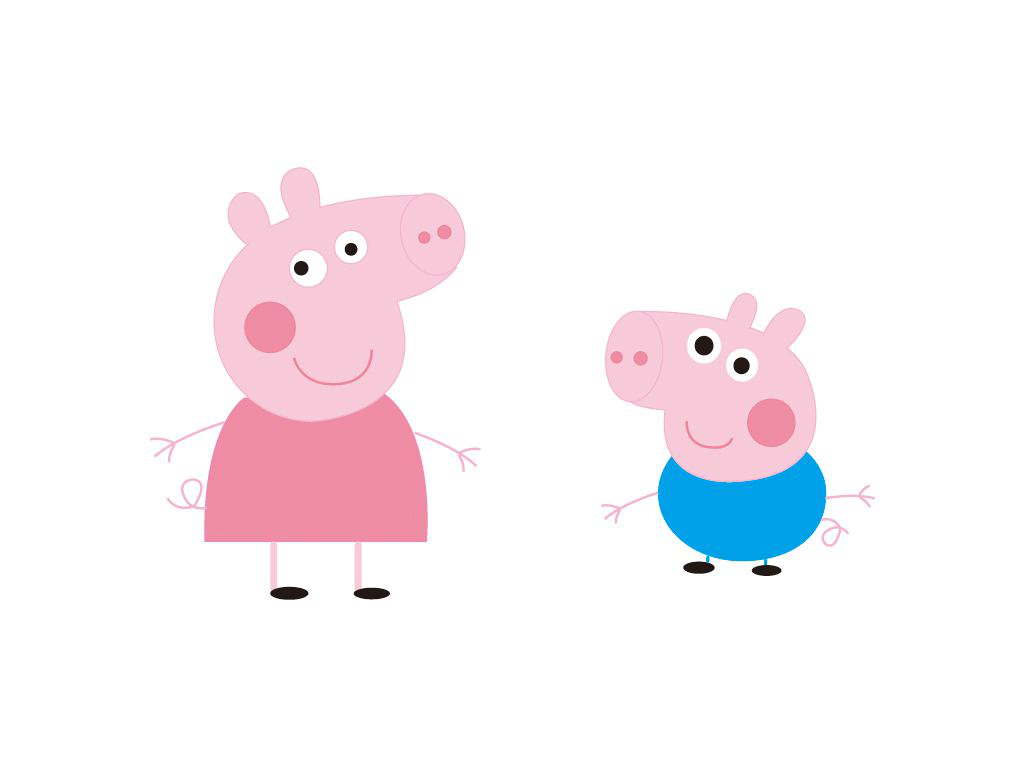

In [ ]:
# 3.图像处理
from PIL import Image
file_name="pig.jpeg"
pig=Image.open(file_name)
pig

In [ ]:
pig.mode,pig.size

('RGB', (1024, 768))

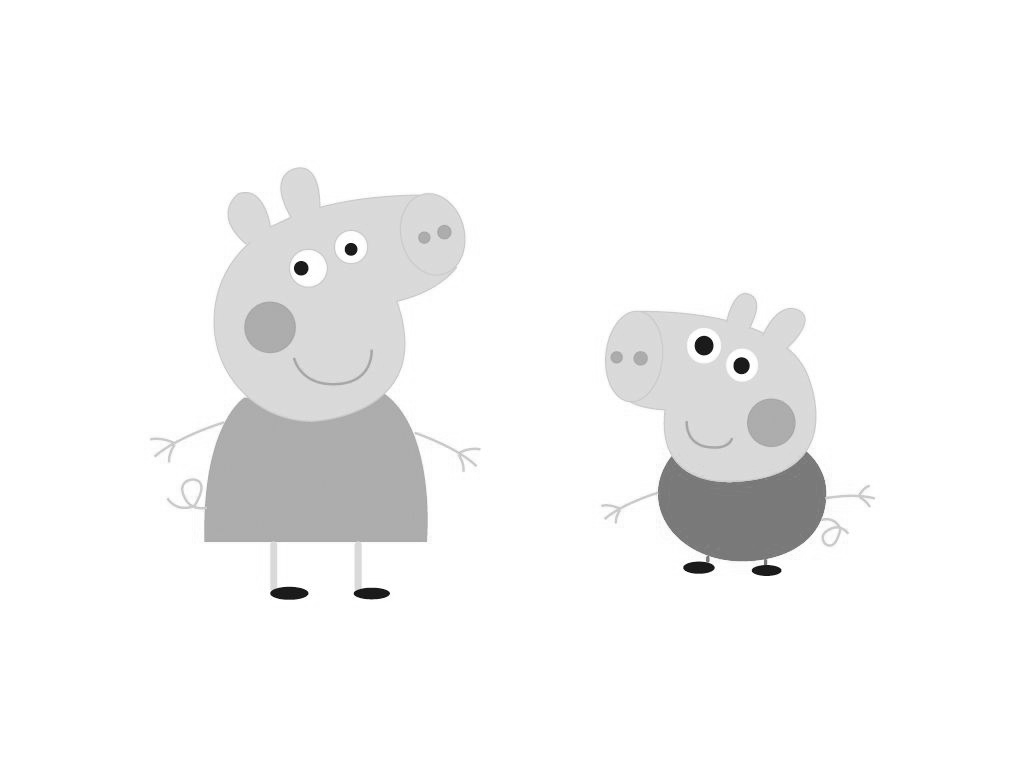

In [ ]:
pig_L=pig.convert("L")
pig_L

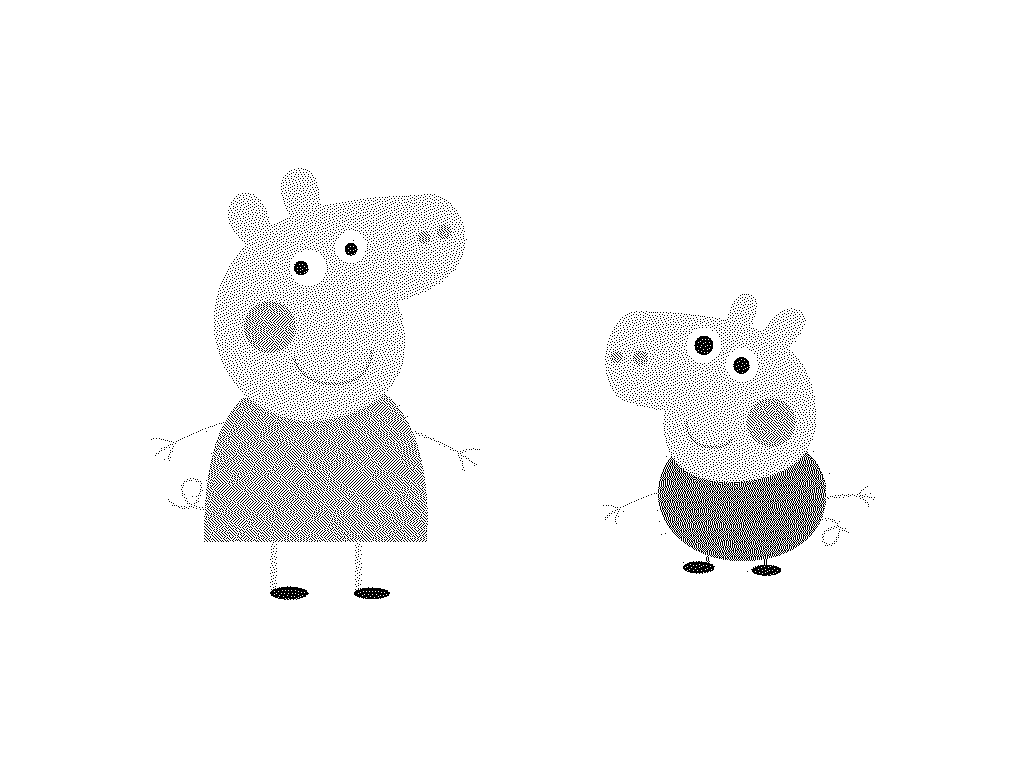

In [ ]:
pig_1=pig.convert("1")
pig_1

In [ ]:

# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
if K.image_dim_ordering() == 'tf':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_dim_ordering() == 'th':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')
model.add(Convolution2D(32, 8, 8, subsample=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 4, 4, subsample=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, subsample=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

# Select a policy. We use eps-greedy action selection, which means that a random action is selected
# with probability eps. We anneal eps from 1.0 to 0.1 over the course of 1M steps. This is done so that
# the agent initially explores the environment (high eps) and then gradually sticks to what it knows
# (low eps). We also set a dedicated eps value that is used during testing. Note that we set it to 0.05
# so that the agent still performs some random actions. This ensures that the agent cannot get stuck.
#policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
#                              nb_steps=1000000)
policy = EpsGreedyQPolicy()

# The trade-off between exploration and exploitation is difficult and an on-going research topic.
# If you want, you can experiment with the parameters or use a different policy. Another popular one
# is Boltzmann-style exploration:
# policy = BoltzmannQPolicy(tau=1.)
# Feel free to give it a try!

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])

plot_model(model, to_file="{}.png".format(os.path.basename(__file__)),show_shapes=True)

if args.mode == 'train':
    # Okay, now it's time to learn something! We capture the interrupt exception so that training
    # can be prematurely aborted. Notice that you can the built-in Keras callbacks!
    weights_filename = 'dqn_{}_weights.h5f'.format(args.env_name)
    checkpoint_weights_filename = 'dqn_' + args.env_name + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format(args.env_name)
    callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
    callbacks += [FileLogger(log_filename, interval=100)]
    #callbacks += [TensorBoard(log_dir = "/tmp/log")]
    dqn.fit(env, callbacks=callbacks, nb_steps=100000, log_interval=10000)

    # After training is done, we save the final weights one more time.
    dqn.save_weights(weights_filename, overwrite=True)

    # Finally, evaluate our algorithm for 10 episodes.
    dqn.test(env, nb_episodes=10, visualize=True)
elif args.mode == 'test':
    weights_filename = 'dqn_{}_weights.h5f'.format(args.env_name)
    if args.weights:
        weights_filename = args.weights
    dqn.load_weights(weights_filename)
    dqn.test(env, nb_episodes=10, visualize=True)
else:
    weights_filename = 'dqn_Pong-100000-v0_weights.h5f'
    if args.weights:
        weights_filename = args.weights
    dqn.load_weights(weights_filename)
    dqn.test(env, nb_episodes=10, visualize=True)